In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier


from imblearn.over_sampling import SMOTE

# Lectura de los datos

In [2]:
train=pd.read_csv('../data_processed/clean/train_data.csv')

In [3]:
test=pd.read_csv('../data_processed/clean/test_data.csv')

In [4]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test.drop('Class', axis=1)
y_test = test['Class']

Aplicamos una tecnica de balanceo, creando datos sinteticos, denominada como SMOTE para balancear los datos favoreciendo modelos. Solo se aplica sobre los datos de entrenamiento ya que los otros datos no se pueden tocar ya que deben simular la vida real. 

In [5]:
smote=SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Prueba de distintos modelos

In [6]:
# Función para calcular métricas tras la predicción
def classification_metrics(y_test, y_pred, name, model=np.NaN, roc_bool=True):
    """
    Calcula y muestra diversas métricas de clasificación tras realizar una predicción.

    Parámetros:
    -----------
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de test.
    y_pred : array-like
        Valores predichos por el modelo.
    name : str
        Nombre o descripción del modelo, utilizado para etiquetar la salida.
    model : object, optional
        Modelo utilizado para hacer la predicción. Se utiliza para calcular la métrica
        ROC-AUC si el modelo soporta la función `predict_proba()`. Por defecto, es np.NaN.
    roc_bool : bool, optional
        Variable para pintar (o no) la curva ROC-AUC.

    Métricas calculadas:
    --------------------
    - Accuracy: Precisión del modelo.
    - Matriz de confusión: Representación de los aciertos y errores del modelo.
    - Reporte de clasificación: Incluye precisión, recall, F1-score, etc.
    - ROC-AUC: Se calcula solo si el modelo soporta `predict_proba()`.
    
    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas del modelo evaluado en la función.
    """
    
    # Calcular la precisión (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Mostrar resultados
    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    metrics_summary = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'ROC-AUC': []}

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calcular y mostrar ROC-AUC si el modelo lo permite y se pide
    if roc_bool:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
            roc_auc = roc_auc_score(y_test, y_proba)
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            print(f"ROC-AUC: {roc_auc:.4f}")
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
            plt.xlabel('Tasa de Falsos Positivos')
            plt.ylabel('Tasa de Verdaderos Positivos')
            plt.title('Curva ROC')
            plt.legend()
            plt.show()
        
        else:
            print(f"ROC-AUC: No disponible para {name}")

     # Almacenar los resultados en el diccionario
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(accuracy)
    metrics_summary['Precision'].append(precision)
    metrics_summary['Recall'].append(recall)
    metrics_summary['F1-Score'].append(f1)
    if roc_bool == True & hasattr(model, "predict_proba"):
        metrics_summary['ROC-AUC'].append(roc_auc)
    else:
        metrics_summary['ROC-AUC'].append(np.NaN)
    
    return pd.DataFrame(metrics_summary)

# Función para entrenar y evaluar modelos
def evaluate_models(models, X_train, X_test, y_train, y_test):
    """
    Entrena y evalúa múltiples modelos de clasificación en un conjunto de datos de prueba.

    Parámetros:
    -----------
    models : dict
        Un diccionario donde las claves son los nombres de los modelos (como cadenas de texto) 
        y los valores son instancias de los modelos de clasificación.
    X_train : array-like
        Características (features) del conjunto de entrenamiento.
    X_test : array-like
        Características (features) del conjunto de prueba.
    y_train : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de entrenamiento.
    y_test : array-like
        Valores verdaderos de la variable objetivo (labels) del conjunto de prueba.

    Funcionalidad:
    --------------
    - Entrena cada modelo en `models` usando el conjunto de entrenamiento `X_train` y `y_train`.
    - Predice los valores de la variable objetivo en `X_test` para cada modelo.
    - Calcula y muestra métricas de clasificación (incluyendo accuracy, matriz de confusión, 
      reporte de clasificación y ROC-AUC si está disponible) utilizando la función 
      `classification_metrics`.

    Devuelve:
    ---------
    data_metrics : pd.DataFrame
        Dataframe con la información de métricas de cada modelo evaluado en la función.
    """

    data_metrics = pd.DataFrame()
    
    # Iterar sobre todos los modelos definidos
    for name, model in models.items():
       
        # Entrenar el modelo
        model.fit(X_train, y_train)
        
        # Predecir en los datos de prueba
        y_pred = model.predict(X_test)

        # Sacar métricas
        df_met_model = classification_metrics(y_test, y_pred, name, model)

        # Métricas training
        print("--- MÉTRICAS CON ENTRENAMIENTO: ---")
        df_met_model_train = classification_metrics(y_train, model.predict(X_train), name, model, roc_bool=False)

        # Renombrar columnas de df_met_model_train para concatenar
        df_met_model_train = df_met_model_train.drop(columns=["ROC-AUC"])
        df_met_model_train.rename(columns={col: col + '_train' for col in df_met_model_train.columns if col != 'Model'}, inplace=True)
        
        # Juntar los dos dataframes en uno
        df_met_model = df_met_model.merge(df_met_model_train, left_on='Model', right_on='Model')
        
        if data_metrics.shape[0] > 0:
            data_metrics = pd.concat([data_metrics, df_met_model])
        else:
            data_metrics = df_met_model

    return data_metrics.reset_index(drop=True).loc[:, ['Model', 'Accuracy_train', 'Accuracy', 'Precision_train', 'Precision', 'Recall_train', 'Recall', 'F1-Score_train', 'F1-Score', 'ROC-AUC']]

In [7]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Predicción de 0 siempre
_ = classification_metrics(y_test, np.zeros(len(y_test), dtype='int64'), "Dummy_0")

# Predicción de 1 siempre
_ = classification_metrics(y_test, np.ones(len(y_test), dtype='int64'), "Dummy_1")


----- Dummy_0 -----
Accuracy: 0.9983
Confusion Matrix:
[[56864     0]
 [   98     0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: No disponible para Dummy_0

----- Dummy_1 -----
Accuracy: 0.0017
Confusion Matrix:
[[    0 56864]
 [    0    98]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56864
           1       0.00      1.00      0.00        98

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962

ROC-AUC: No disponible para Dummy_1


Podemos ver claramente el desbalanceo en el accuracy de los datos por lo que si no hubiesemos hecho el SMOTE nos habria dado mas datos para el 0.

Vamos a probar ahora distintos modelos para ver como rinden.


----- Logistic Regression -----
Accuracy: 0.8481
Confusion Matrix:
[[48233  8631]
 [   23    75]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     56864
           1       0.01      0.77      0.02        98

    accuracy                           0.85     56962
   macro avg       0.50      0.81      0.47     56962
weighted avg       1.00      0.85      0.92     56962

ROC-AUC: 0.8737


/opt/miniconda3/envs/agg_pml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


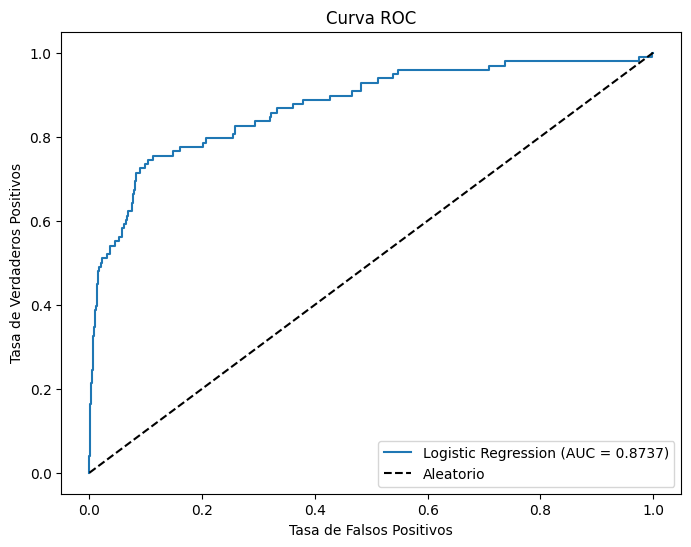

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Logistic Regression -----
Accuracy: 0.8481
Confusion Matrix:
[[192936  34515]
 [    98    296]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92    227451
           1       0.01      0.75      0.02       394

    accuracy                           0.85    227845
   macro avg       0.50      0.80      0.47    227845
weighted avg       1.00      0.85      0.92    227845


----- Random Forest -----
Accuracy: 0.9992
Confusion Matrix:
[[56858     6]
 [   41    57]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.58      0.71        98

    accuracy                           1.00     56962
   macro avg       0.95      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9573


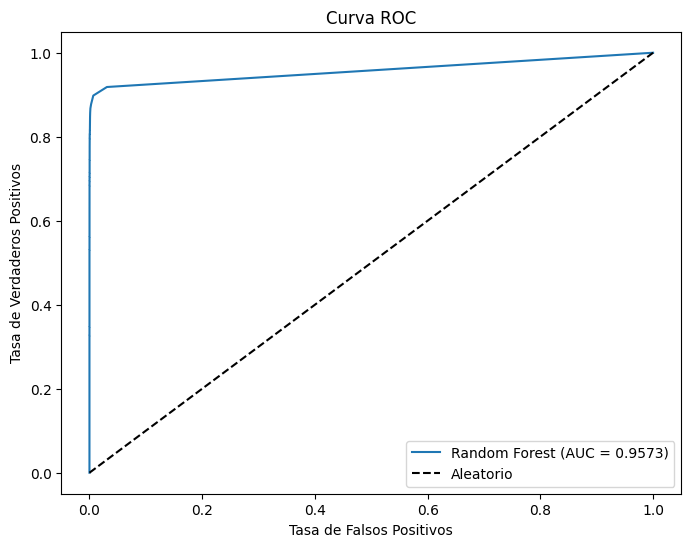

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Random Forest -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845


----- Decision Tree -----
Accuracy: 0.9987
Confusion Matrix:
[[56828    36]
 [   36    62]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.63      0.63        98

    accuracy                           1.00     56962
   macro avg       0.82      0.82      0.82     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8160


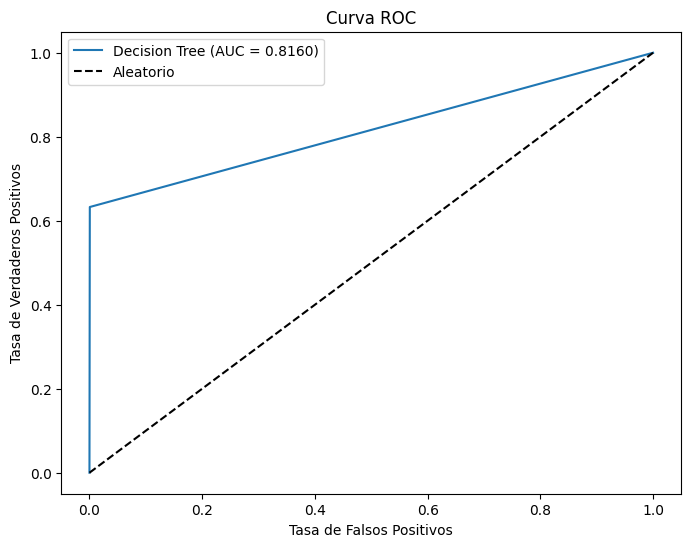

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Decision Tree -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [In

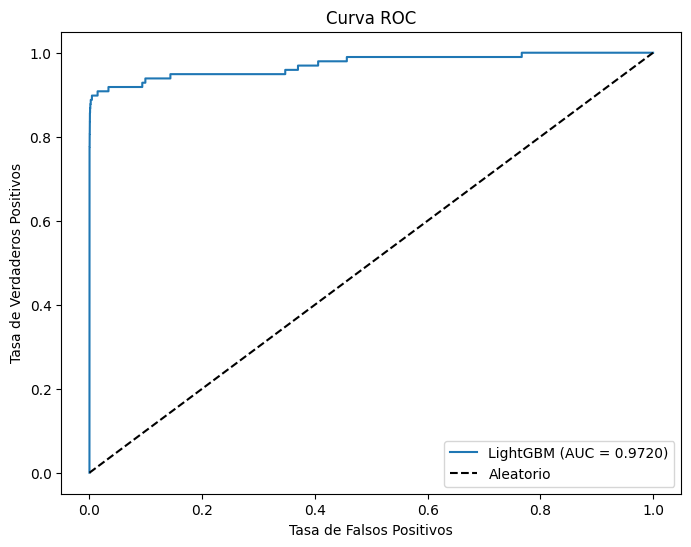

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- LightGBM -----
Accuracy: 0.9997
Confusion Matrix:
[[227379     72]
 [     0    394]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.85      1.00      0.92       394

    accuracy                           1.00    227845
   macro avg       0.92      1.00      0.96    227845
weighted avg       1.00      1.00      1.00    227845



In [15]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
}

metrics_summary = evaluate_models(models, X_train, X_test, y_train, y_test)



----- Logistic Regression -----
Accuracy: 0.8658
Confusion Matrix:
[[49240  7624]
 [   23    75]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.77      0.02        98

    accuracy                           0.87     56962
   macro avg       0.50      0.82      0.47     56962
weighted avg       1.00      0.87      0.93     56962

ROC-AUC: 0.8694


/opt/miniconda3/envs/agg_pml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


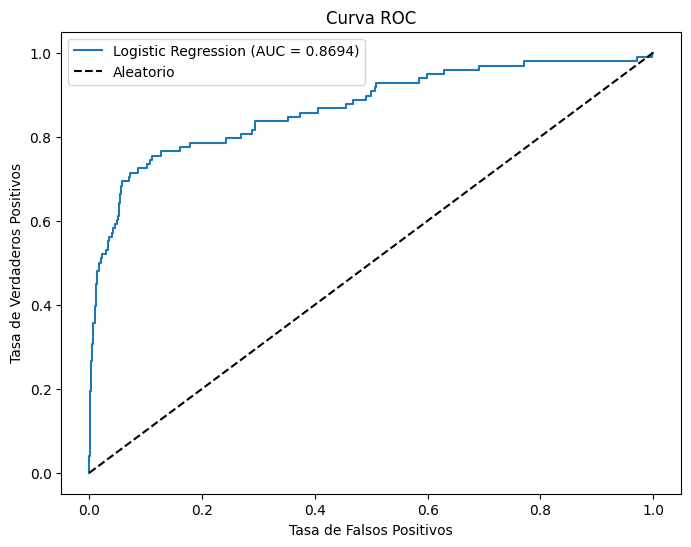

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Logistic Regression -----
Accuracy: 0.8275
Confusion Matrix:
[[196840  30611]
 [ 47855 179596]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83    227451
           1       0.85      0.79      0.82    227451

    accuracy                           0.83    454902
   macro avg       0.83      0.83      0.83    454902
weighted avg       0.83      0.83      0.83    454902


----- Random Forest -----
Accuracy: 0.9991
Confusion Matrix:
[[56844    20]
 [   30    68]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.77      0.69      0.73        98

    accuracy                           1.00     56962
   macro avg       0.89      0.85      0.87     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9533


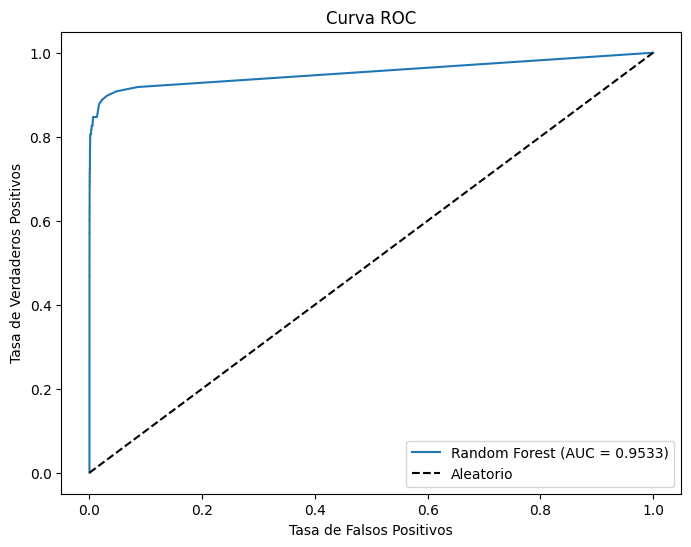

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Random Forest -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902


----- Decision Tree -----
Accuracy: 0.9960
Confusion Matrix:
[[56674   190]
 [   38    60]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.61      0.34        98

    accuracy                           1.00     56962
   macro avg       0.62      0.80      0.67     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8045


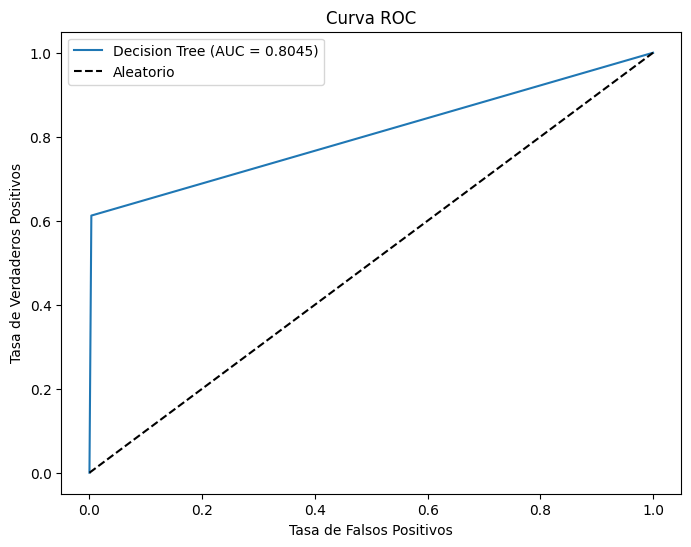

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- Decision Tree -----
Accuracy: 1.0000
Confusion Matrix:
[[227451      0]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

[LightGBM] [Info] Number of positive: 227451, number of negative: 227451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454902, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

----- Ligh

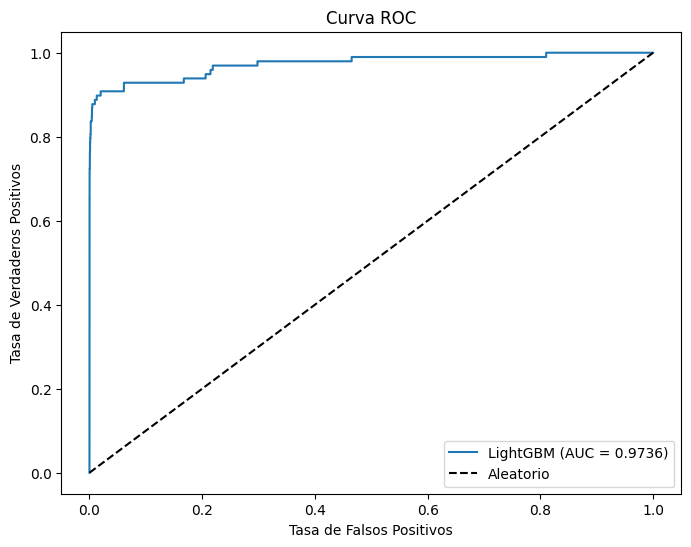

--- MÉTRICAS CON ENTRENAMIENTO: ---

----- LightGBM -----
Accuracy: 0.9986
Confusion Matrix:
[[226796    655]
 [     0 227451]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [17]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1,random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
}

metrics_summary=evaluate_models(models,X_train_bal, X_test,y_train_bal, y_test )